In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.special import boxcox, inv_boxcox
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")


In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        # plt.tight_layout()
    plt.show()
    return

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
series = dowjones_closing['Close']

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


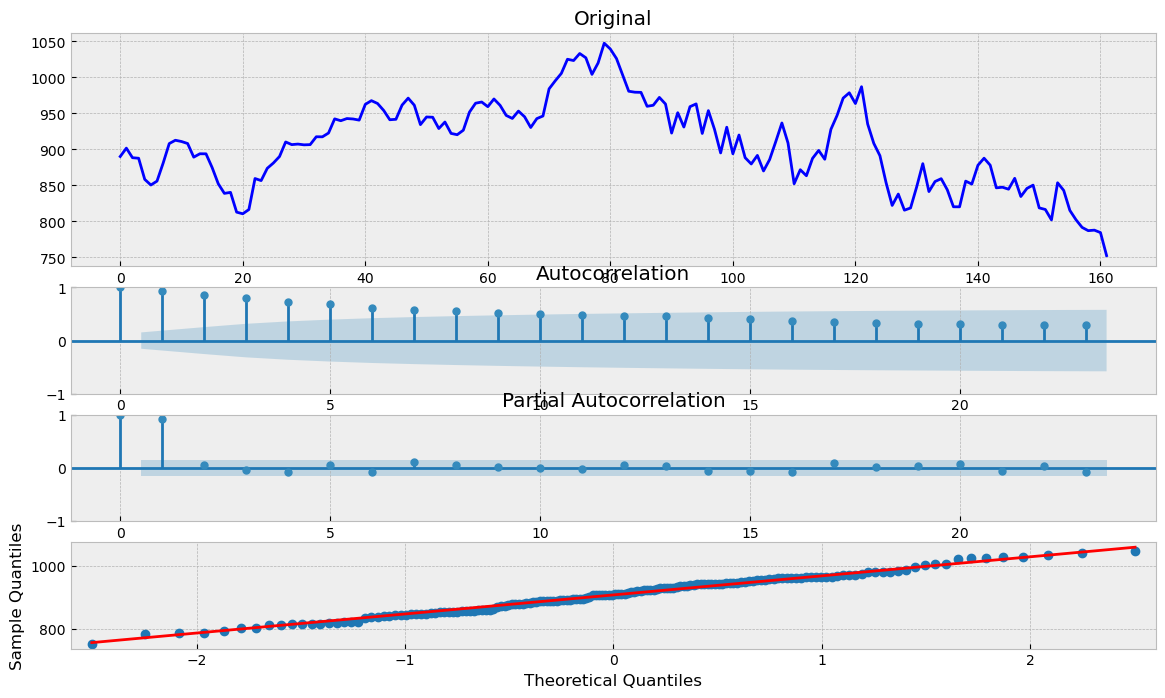

In [7]:
tsplot(series)

In [8]:
def get_best_ARIMA(y, trend = 'c'):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    for i in range(5):
        for d in range(5):
            for j in range(5):
                tmp_mdl = ARIMA(y, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_mdl = tmp_mdl
                    best_order = (i, d, j)
    print(best_order)
    return best_mdl


Определяем лучшие параметры ARIMA

In [9]:
arima1 = get_best_ARIMA(series)


(2, 2, 3)


In [13]:
rmse(series, arima1.predict())


80.15211463266081

In [68]:
garch_model=arch_model(series, p=2, o=2, q=3)
results=garch_model.fit()

Iteration:      1,   Func. Count:     11,   Neg. LLF: 1160.8652296019964
Iteration:      2,   Func. Count:     22,   Neg. LLF: 855.9148173447372
Iteration:      3,   Func. Count:     32,   Neg. LLF: 858.0280934975017
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1162.2061424008211
Iteration:      5,   Func. Count:     54,   Neg. LLF: 911.5832604077707
Iteration:      6,   Func. Count:     66,   Neg. LLF: 853.6673003958487
Iteration:      7,   Func. Count:     76,   Neg. LLF: 853.4986029635229
Iteration:      8,   Func. Count:     86,   Neg. LLF: 853.4832813518649
Iteration:      9,   Func. Count:     96,   Neg. LLF: 853.4692902424249
Iteration:     10,   Func. Count:    106,   Neg. LLF: 853.4641510524098
Iteration:     11,   Func. Count:    116,   Neg. LLF: 853.4555425720995
Iteration:     12,   Func. Count:    126,   Neg. LLF: 853.4474057079066
Iteration:     13,   Func. Count:    136,   Neg. LLF: 853.4367100912004
Iteration:     14,   Func. Count:    146,   Neg. LLF: 853.4288

In [69]:
results

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -853.317
Distribution:                  Normal   AIC:                           1724.63
Method:            Maximum Likelihood   BIC:                           1752.42
                                        No. Observations:                  162
Date:                Thu, Nov 21 2024   Df Residuals:                      161
Time:                        18:53:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           908.1431     11.476     79.134      0.000 [8.

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


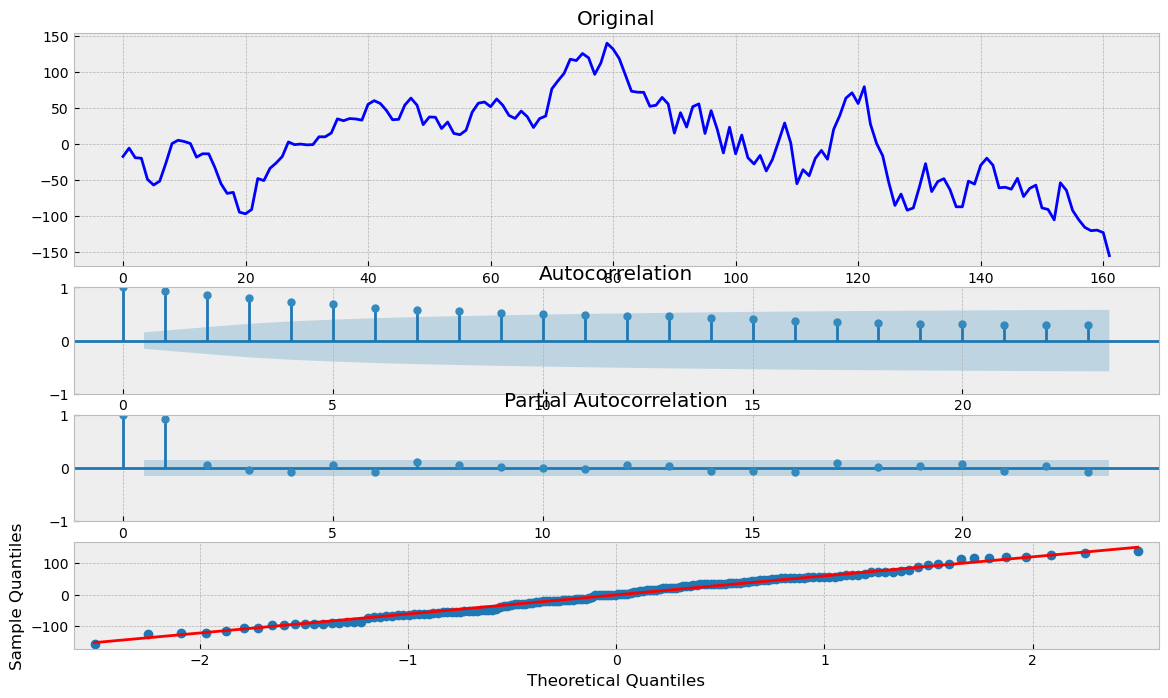

In [70]:
tsplot(results.resid)